In [1]:
!pip install torchview
!pip install graphviz
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import math
from torchvision import models as torch_model
import numpy as np
import torch.nn as nn
import graphviz
from torchview import draw_graph
import os
from matplotlib import pyplot as plot
import time

In [63]:
batch_size = 64
epochs = 20
num_classes = 10
dir_name = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

100%|██████████| 170498071/170498071 [00:04<00:00, 39221357.76it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [4]:
means = []
stdevs = []
for X, _ in train_data_loader:
    # Dimensions 0,2,3 are respectively the batch, height and width dimensions
    means.append(X.mean(dim=(0,2,3)))
    stdevs.append(X.std(dim=(0,2,3)))

mean = torch.stack(means, dim=0).mean(dim=0)
stdev = torch.stack(stdevs, dim=0).mean(dim=0)

In [5]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])

valid_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])

In [6]:
import time

def train(net, train_dataloader, criterion, optimizer, scheduler=None, epochs=10, checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}", end=" ")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}; Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [16]:
def get_resnet34(conf):
  weights=torchvision.models.ResNet34_Weights.DEFAULT.transforms()
  resnet = torchvision.models.resnet34(weights=weights)
  resnet.to(device)
  if conf == 1:
    features_count = resnet.fc.in_features
    resnet.fc = torch.nn.Linear(features_count, 10)
  else:
    for prm_of_model in resnet.parameters():
      prm_of_model.requires_grad = False
    features_count = resnet.fc.in_features
    resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(features_count, features_count//2),
    torch.nn.ReLU(),
    torch.nn.Linear(features_count//2, 10),
    )
  return resnet

lr = 0.01

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

In [14]:
# FIRST RESNET18

net = get_resnet34(1).to(device)
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.SGD([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr=lr)
net = train(net, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.04; Training accuracy: 64.78
Epoch 2/10 Training loss: 0.61; Training accuracy: 79.20
Epoch 3/10 Training loss: 0.45; Training accuracy: 84.42
Epoch 4/10 Training loss: 0.34; Training accuracy: 88.20
Epoch 5/10 Training loss: 0.26; Training accuracy: 90.89
Epoch 6/10 Training loss: 0.27; Training accuracy: 90.70
Epoch 7/10 Training loss: 0.16; Training accuracy: 94.48
Epoch 8/10 Training loss: 0.12; Training accuracy: 95.81
Epoch 9/10 Training loss: 0.09; Training accuracy: 96.86
Epoch 10/10 Training loss: 0.07; Training accuracy: 97.47
Total training time: 208.5 seconds


In [17]:
# SECOND RESNET18

net2 = get_resnet34(2).to(device)
params_1x = [param for name, param in net2.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.SGD([{'params':params_1x}, {'params': net2.fc.parameters(), 'lr': lr*10}], lr=lr)
net2 = train(net2, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.69; Training accuracy: 39.98
Epoch 2/10 Training loss: 1.53; Training accuracy: 46.03
Epoch 3/10 Training loss: 1.47; Training accuracy: 47.80
Epoch 4/10 Training loss: 1.44; Training accuracy: 49.14
Epoch 5/10 Training loss: 1.40; Training accuracy: 50.35
Epoch 6/10 Training loss: 1.37; Training accuracy: 51.32
Epoch 7/10 Training loss: 1.36; Training accuracy: 52.36
Epoch 8/10 Training loss: 1.34; Training accuracy: 52.86
Epoch 9/10 Training loss: 1.32; Training accuracy: 53.55
Epoch 10/10 Training loss: 1.31; Training accuracy: 54.18
Total training time: 130.3 seconds


In [19]:
def get_resnet50(conf):
  weights=torchvision.models.ResNet50_Weights.DEFAULT.transforms()
  resnet = torchvision.models.resnet50(weights=weights)
  resnet.to(device)
  if conf == 1:
    features_count = resnet.fc.in_features
    resnet.fc = torch.nn.Linear(features_count, 10)
  else:
    for prm_of_model in resnet.parameters():
      prm_of_model.requires_grad = False
    features_count = resnet.fc.in_features
    resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(features_count, features_count//2),
    torch.nn.ReLU(),
    torch.nn.Linear(features_count//2, 10),
    )
  return resnet

In [20]:
# FIRST RESNET50

net50 = get_resnet50(1).to(device)
params_1x = [param for name, param in net50.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.SGD([{'params':params_1x}, {'params': net50.fc.parameters(), 'lr': lr*10}], lr=lr)
net50 = train(net50, train_data_loader, criterion, optimizer, None, 10, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.7MB/s]


Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.63; Training accuracy: 49.29
Epoch 2/10 Training loss: 0.83; Training accuracy: 70.77
Epoch 3/10 Training loss: 0.71; Training accuracy: 75.31
Epoch 4/10 Training loss: 0.51; Training accuracy: 82.14
Epoch 5/10 Training loss: 0.40; Training accuracy: 86.11
Epoch 6/10 Training loss: 0.30; Training accuracy: 89.59
Epoch 7/10 Training loss: 0.23; Training accuracy: 92.05
Epoch 8/10 Training loss: 0.17; Training accuracy: 94.01
Epoch 9/10 Training loss: 0.17; Training accuracy: 94.01
Epoch 10/10 Training loss: 0.11; Training accuracy: 96.35
Total training time: 276.0 seconds


In [22]:
# SECOND RESNET50

net502 = get_resnet50(2).to(device)
params_1x = [param for name, param in net502.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.SGD([{'params':params_1x}, {'params': net502.fc.parameters(), 'lr': lr*10}], lr=lr)
net502 = train(net502, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.67; Training accuracy: 40.48
Epoch 2/10 Training loss: 1.48; Training accuracy: 47.74
Epoch 3/10 Training loss: 1.40; Training accuracy: 50.59
Epoch 4/10 Training loss: 1.35; Training accuracy: 52.49
Epoch 5/10 Training loss: 1.30; Training accuracy: 54.25
Epoch 6/10 Training loss: 1.26; Training accuracy: 55.73
Epoch 7/10 Training loss: 1.23; Training accuracy: 56.62
Epoch 8/10 Training loss: 1.20; Training accuracy: 57.89
Epoch 9/10 Training loss: 1.17; Training accuracy: 59.07
Epoch 10/10 Training loss: 1.15; Training accuracy: 59.81
Total training time: 160.1 seconds


In [33]:
def get_vgg(conf):
  vgg = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)
  vgg = vgg.to(device)
  if conf == 1:
    vgg.classifier = torch.nn.Linear(25088, 10)
  else:
    for prm_of_model in vgg.parameters():
      prm_of_model.requires_grad = False
    number_features = vgg.classifier[6].in_features
    features = list(vgg.classifier.children())[:-1] # Remove last layer
    features.extend([torch.nn.Linear(number_features, 10)])
    vgg.classifier = torch.nn.Sequential(*features)
  return vgg

In [27]:
netvgg = get_vgg(1).to(device)
optimizer = torch.optim.SGD(netvgg.parameters(), lr=lr, momentum=0.9)
netvgg = train(netvgg, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 0.86; Training accuracy: 71.19
Epoch 2/10 Training loss: 0.46; Training accuracy: 84.91
Epoch 3/10 Training loss: 0.33; Training accuracy: 89.14
Epoch 4/10 Training loss: 0.24; Training accuracy: 91.88
Epoch 5/10 Training loss: 0.18; Training accuracy: 93.92
Epoch 6/10 Training loss: 0.15; Training accuracy: 95.07
Epoch 7/10 Training loss: 0.12; Training accuracy: 96.21
Epoch 8/10 Training loss: 0.10; Training accuracy: 96.66
Epoch 9/10 Training loss: 0.08; Training accuracy: 97.42
Epoch 10/10 Training loss: 0.07; Training accuracy: 97.85
Total training time: 285.7 seconds


In [66]:
netvgg2 = get_vgg(2).to(device)
optimizer = torch.optim.SGD(netvgg2.parameters(), lr=lr, momentum=0.9)
netvgg2 = train(netvgg2, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 3.25; Training accuracy: 39.52
Epoch 2/10 Training loss: 3.54; Training accuracy: 41.18
Epoch 3/10 Training loss: 3.62; Training accuracy: 41.50
Epoch 4/10 Training loss: 3.64; Training accuracy: 41.93
Epoch 5/10 Training loss: 3.62; Training accuracy: 42.63
Epoch 6/10 Training loss: 3.63; Training accuracy: 42.50
Epoch 7/10 Training loss: 3.61; Training accuracy: 42.39
Epoch 8/10 Training loss: 3.61; Training accuracy: 42.61
Epoch 9/10 Training loss: 3.63; Training accuracy: 42.68
Epoch 10/10 Training loss: 3.65; Training accuracy: 42.66
Total training time: 150.2 seconds


In [67]:
def get_googlenet(conf):
  weights=torchvision.models.GoogLeNet_Weights.DEFAULT
  googlenet = torchvision.models.googlenet(weights=weights)
  googlenet.to(device)
  if conf == 1:
    features_count = googlenet.fc.in_features
    googlenet.fc = torch.nn.Linear(features_count, 10)
  else:
    for prm_of_model in googlenet.parameters():
      prm_of_model.requires_grad = False
    features_count = googlenet.fc.in_features
    googlenet.fc = torch.nn.Sequential(
    torch.nn.Linear(features_count, features_count//2),
    torch.nn.ReLU(),
    torch.nn.Linear(features_count//2, 10),
    )
  return googlenet

In [69]:
googlenet = get_googlenet(1).to(device)
optimizer = torch.optim.SGD(googlenet.parameters(), lr=lr, momentum=0.9)
googlenet = train(googlenet, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.05; Training accuracy: 64.16
Epoch 2/10 Training loss: 0.64; Training accuracy: 78.23
Epoch 3/10 Training loss: 0.49; Training accuracy: 83.42
Epoch 4/10 Training loss: 0.39; Training accuracy: 86.59
Epoch 5/10 Training loss: 0.32; Training accuracy: 88.95
Epoch 6/10 Training loss: 0.27; Training accuracy: 90.71
Epoch 7/10 Training loss: 0.22; Training accuracy: 92.54
Epoch 8/10 Training loss: 0.20; Training accuracy: 93.26
Epoch 9/10 Training loss: 0.17; Training accuracy: 94.19
Epoch 10/10 Training loss: 0.14; Training accuracy: 95.11
Total training time: 303.7 seconds


In [70]:
googlenet2 = get_googlenet(2).to(device)
optimizer = torch.optim.SGD(googlenet2.parameters(), lr=lr, momentum=0.9)
googlenet2 = train(googlenet2, train_data_loader, criterion, optimizer, None, 10, device)

Training for 10 epochs on cuda:0
Epoch 1/10 Training loss: 1.90; Training accuracy: 32.61
Epoch 2/10 Training loss: 1.78; Training accuracy: 37.35
Epoch 3/10 Training loss: 1.73; Training accuracy: 38.76
Epoch 4/10 Training loss: 1.70; Training accuracy: 39.94
Epoch 5/10 Training loss: 1.67; Training accuracy: 41.07
Epoch 6/10 Training loss: 1.64; Training accuracy: 41.76
Epoch 7/10 Training loss: 1.63; Training accuracy: 42.50
Epoch 8/10 Training loss: 1.60; Training accuracy: 43.44
Epoch 9/10 Training loss: 1.59; Training accuracy: 43.97
Epoch 10/10 Training loss: 1.57; Training accuracy: 44.71
Total training time: 180.7 seconds


In [74]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [75]:
nets = ["resnet34_one", "resnet34_two","resnet50_one","resnet50_two", "googlenet_one", "googlenet_two","vgg_one","vgg_two" ]
nets_acc = []

In [76]:
acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = net(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = net2(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

Average accuracy: 0.90625
Average accuracy: 0.59375


In [77]:
acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = net50(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = net502(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

Average accuracy: 0.921875
Average accuracy: 0.640625


In [78]:
acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = googlenet(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = googlenet2(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

Average accuracy: 0.953125
Average accuracy: 0.5625


In [79]:
acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = netvgg(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

acc = -1
i = 0
with torch.no_grad():
    for X, Y in test_data_loader:
        i += 1
        X = X.to(device)
        pred = netvgg2(X).argmax(dim=1).type(torch.int32).cpu().numpy()
        acc = max(acc, get_accuracy(pred, Y.numpy()))
nets_acc.append(acc)
print(f'Average accuracy: {acc}')

Average accuracy: 0.984375
Average accuracy: 0.5625


<BarContainer object of 8 artists>

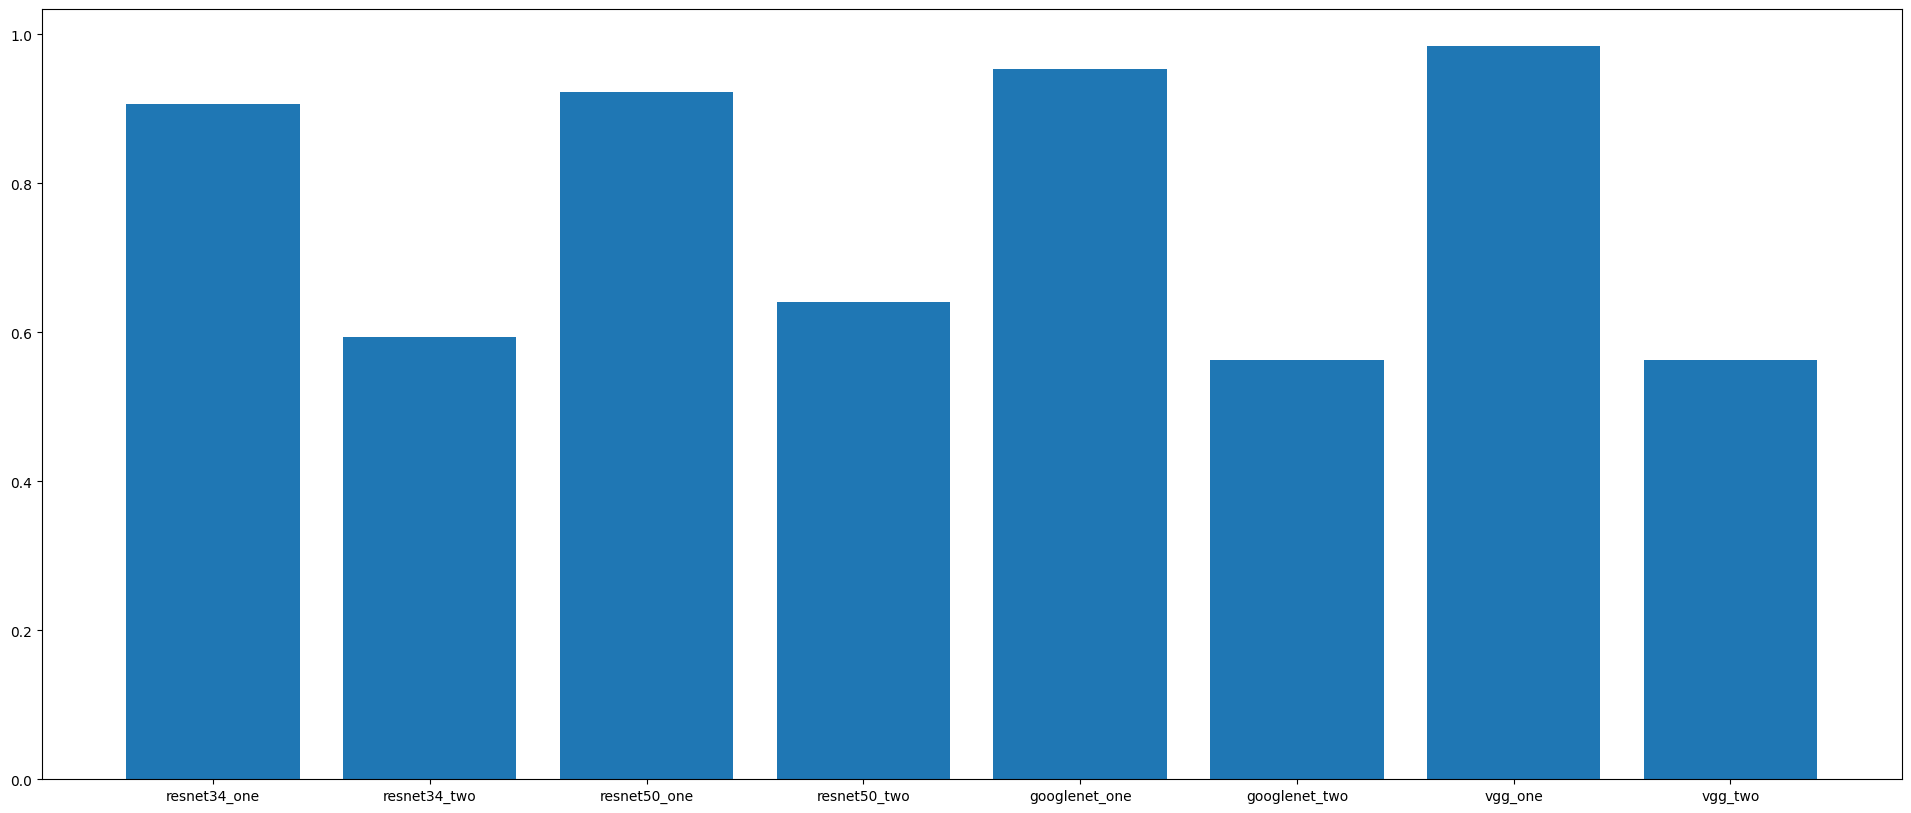

In [81]:
plot.figure(figsize = (24, 10))
plot.bar(nets, nets_acc)

In [ ]:
%%shell
jupyter nbconvert --to html /content/KrylovaEV.ipynb

[NbConvertApp] Converting notebook /content/KrylovaEV.ipynb to html
[NbConvertApp] Writing 607325 bytes to /content/KrylovaEV.html
